In [1]:
from spice.models import IcosphereModel
from transformer_payne import TransformerPayne
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# os.environ['TF_CPP_MIN_VLOG_LEVEL'] = '3'

# import jax
# jax.config.update("jax_enable_x64", False)

import jax.numpy as jnp
# Initialize a Blackbody model (for spectrum calculation)
tp = TransformerPayne.download()

# Create an icosphere model
m = IcosphereModel.construct(1000, 1., 1.,
                             tp.to_parameters(dict(logteff=jnp.log10(7000), logg=4.3, O=8.0, Si=6.0)),
                             tp.stellar_parameter_names)

/home/ubuntu/miniconda3/envs/spice/lib/python3.13/site-packages/transformer_payne/transformer_payne.py:576: UserWarning: Possible exceeding parameter bonds - extrapolating.
  warnings.warn("Possible exceeding parameter bonds - extrapolating.")


In [6]:
from spice.models.spots import add_spot
from spice.models.mesh_transform import add_rotation, evaluate_rotation
import numpy as np

timestamps = np.linspace(0, 48*3600, 100)

m_spotted = add_spot(m, spot_center_theta=1., spot_center_phi=1., spot_radius=30., parameter_delta=5.0, parameter_index=tp.parameter_names.index('Mn'))
m_spotted = [evaluate_rotation(add_rotation(m_spotted, 25.), t) for t in timestamps]

import jax
jax.config.update("jax_default_matmul_precision", "float32")

In [7]:
from spice.spectrum.spectrum import simulate_observed_flux
from tqdm import tqdm

vws = np.linspace(4762, 4769, 2000)
spec_rot_spotted = [simulate_observed_flux(tp.intensity, _m_spotted, jnp.log10(vws)) for _m_spotted in tqdm(m_spotted)]

  0%|                                                                                                                                                         | 0/100 [00:00<?, ?it/s]/home/ubuntu/miniconda3/envs/spice/lib/python3.13/site-packages/jax/_src/linear_util.py:193: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in logspace is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  ans = self.f(*args, **dict(self.params, **kwargs))
/home/ubuntu/miniconda3/envs/spice/lib/python3.13/site-packages/jax/_src/numpy/lax_numpy.py:6815: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See h

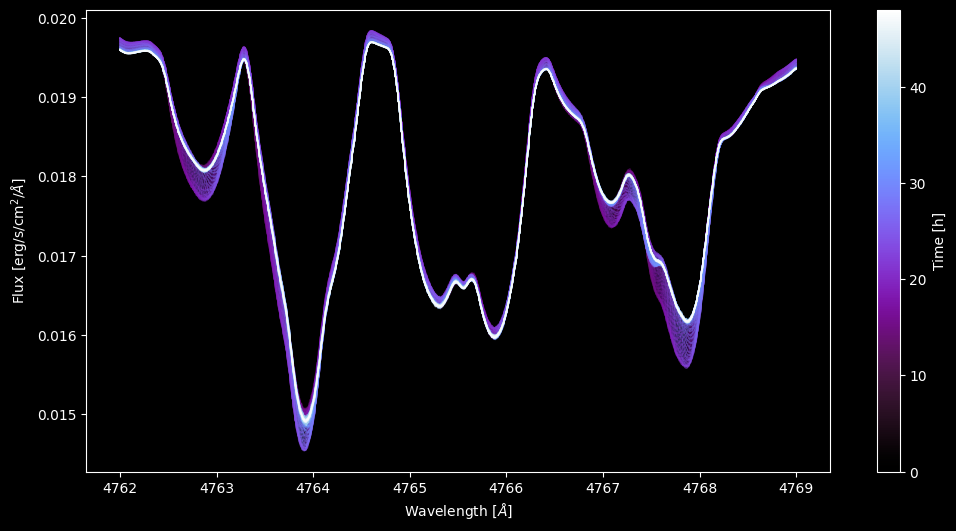

In [18]:
import cmasher as cmr

plt.style.use('dark_background')

_, ax = plt.subplots(figsize=(12, 6))
# Plot the spectra with colors based on timesteps
# Create color map for different timesteps using magma
colormap = cmr.voltage

colors = colormap(np.linspace(0, 1, len(spec_rot_spotted)))

# Plot each spectrum with color based on timestep
for i, spectrum in enumerate(spec_rot_spotted):
    plt.plot(vws, spectrum[:, 0], color=colors[i], linewidth=1, alpha=0.5)

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=0, vmax=timestamps[-1]/(3600)))
plt.colorbar(sm, ax=ax, label='Time [h]')

# Add a colorbar
ax.set_xlabel(r'Wavelength [$\AA$]')
ax.set_ylabel(r'Flux [erg/s/cm$^2$/$\AA$]')
plt.show()

In [6]:
timestamps = jnp.linspace(0, period_s, 100)
import jax

mt_rot_ev = [evaluate_rotation(mt, t) for t in timestamps]

(<Figure size 1000x1200 with 2 Axes>,
 <Axes3DSubplot:xlabel='$X [R_\\odot]$', ylabel='$Y [R_\\odot]$'>)

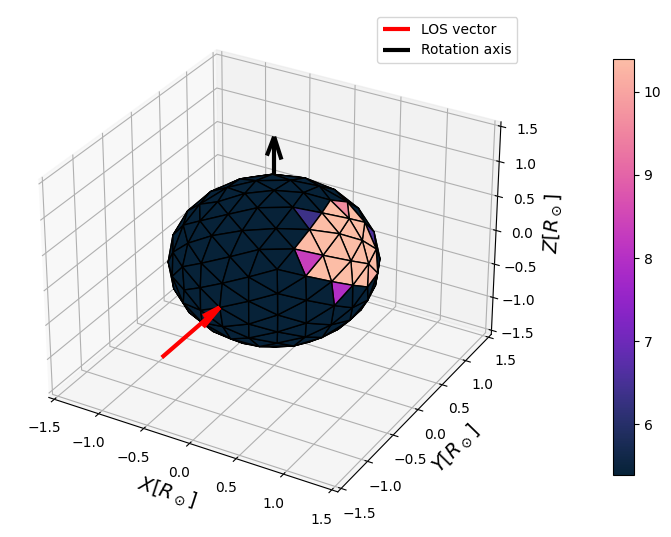

In [6]:
from spice.plots.plot_mesh import plot_3D


plot_3D(mt_rot_ev[16], property=tp.parameter_names.index('Mn'))

In [8]:
vws = jnp.linspace(4670, 4960, 100)
simulate_observed_flux(tp.intensity, mt_rot_ev[17], jnp.log10(vws))

Array([[0.02033452, 0.02036456],
       [0.02038538, 0.02037988],
       [0.02047366, 0.02051169],
       [0.01921269, 0.02014541],
       [0.01825967, 0.01989964],
       [0.0194758 , 0.0203866 ],
       [0.01846758, 0.02009634],
       [0.01982317, 0.02030178],
       [0.01977299, 0.02043801],
       [0.01928347, 0.02017206],
       [0.0198919 , 0.02048558],
       [0.01750567, 0.01997531],
       [0.01479057, 0.02016696],
       [0.01604494, 0.01987755],
       [0.01837572, 0.01998187],
       [0.0200586 , 0.02044498],
       [0.01768989, 0.01991189],
       [0.01906139, 0.02004747],
       [0.01903816, 0.02008567],
       [0.01861698, 0.02000871],
       [0.01671696, 0.01981852],
       [0.01449192, 0.02003508],
       [0.01907246, 0.02006878],
       [0.01842625, 0.0200722 ],
       [0.01728644, 0.01934405],
       [0.01834207, 0.01958336],
       [0.01835386, 0.01940591],
       [0.01695725, 0.01961432],
       [0.01923882, 0.01968459],
       [0.01914761, 0.0197075 ],
       [0.

In [10]:
import gc
from pympler import muppy
import resource
import time

vws = jnp.linspace(4670, 4960, 100)
specs = []

# prev_sum = summary.summarize(muppy.get_objects())
# prev_mem = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss


for i, _mt in enumerate(mt_rot_ev[:20]):
    print(i)
    start_time = time.time()
    specs.append(simulate_observed_flux(tp.intensity, _mt, jnp.log10(vws)))
    end_time = time.time()
    print(f"{i} Time taken: {end_time - start_time} seconds")
    # print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss - prev_mem)
    # prev_mem = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    # new_sum = summary.summarize(muppy.get_objects())
    # summary.print_(summary.get_diff(prev_sum, new_sum))
    # prev_sum = new_sum

0
0 Time taken: 19.93827199935913 seconds
1
1 Time taken: 28.963608026504517 seconds
2
2 Time taken: 28.32654118537903 seconds
3
3 Time taken: 32.193812131881714 seconds
4
4 Time taken: 36.711251974105835 seconds
5
5 Time taken: 27.503363847732544 seconds
6


KeyboardInterrupt: 

In [8]:
with jax.profiler.trace("tmp/jax-trace"):
    spec = simulate_observed_flux(tp.intensity, mt_rot_ev[16], jnp.log10(vws))
    spec.block_until_ready()

In [9]:
from spice.plots.plot_mesh import plot_3D


plot_3D(mt_rot_ev[16], property='los_velocities')

In [10]:
for i, _mt in enumerate(mt_rot_ev[::5]):

    print(i)
    specs.append()

0
1
2
3


In [3]:
from spice.plots.plot_mesh import plot_3D


plt.style.use('dark_background')
fig, plot_ax = plot_3D(mt_rot[0], property_label='Mn abundance', property=tp.parameter_names.index('Mn'))

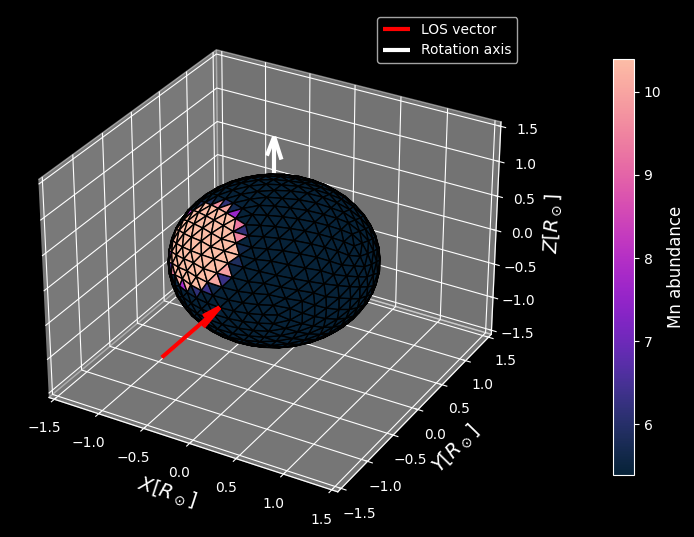

In [7]:
fig, plot_ax = plot_3D(mt_rot[50], property_label='Mn abundance', property=tp.parameter_names.index('Mn'))

In [61]:
from tqdm import tqdm
vws = np.linspace(4762, 4769, 2000)
spec_rot_spotted = [simulate_observed_flux(tp.intensity, _m_spotted, jnp.log10(vws)) for _m_spotted in tqdm(mt_rot_ev)]

  0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
from spice.models.mesh_transform import add_pulsation, evaluate_pulsations
import jax.numpy as jnp

# Create a basic model (assuming 'm' is already defined)

# Add a tilted pulsation
tilted_m = add_pulsation(
    m,  # Model instance
    0,  # m order
    1,  # n degree
    2.,  # pulsation period
    jnp.array([[1e-1, 0.]]),  # Fourier series parameters
    pulsation_axes=jnp.array([0., 1., 0.]),  # Tilt axis (y-axis in this case)
    pulsation_angles=jnp.array([45.])  # Tilt angle in degrees
)

t = 0.5  # time in the same unit as the pulsation period
tilted_pulsated_m = evaluate_pulsations(tilted_m, t)

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:231: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


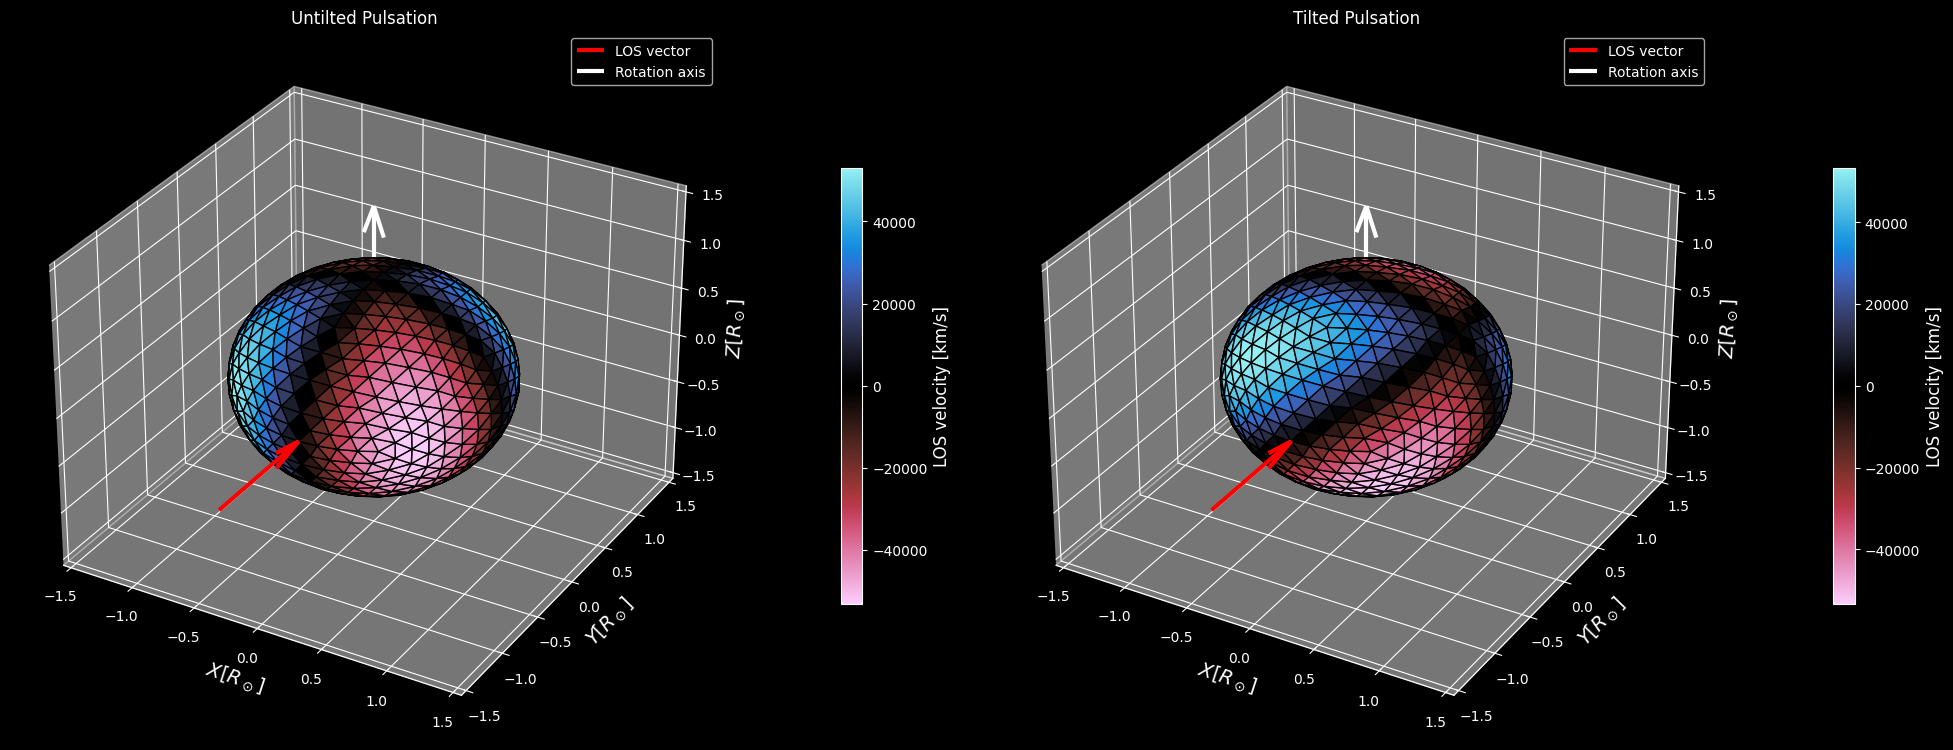

In [17]:
from spice.plots.plot_mesh import plot_3D
import matplotlib.pyplot as plt

plt.style.use('dark_background')
# Create an untilted pulsation for comparison
m = IcosphereModel.construct(1000, 1., 1.,
                            bb.to_parameters(), bb.parameter_names)
untilted_m = add_pulsation(m, 0, 1, 2., jnp.array([[1e-1, 0.]]))
tilted_m = add_pulsation(m, 0, 1, 2., jnp.array([[1e-1, 0.]]), pulsation_axes=jnp.array([0., 1., 0.]), pulsation_angles=jnp.array([45.]))

untilted_pulsated_m = evaluate_pulsations(untilted_m, 0.5)
tilted_pulsated_m = evaluate_pulsations(tilted_m, 0.5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': '3d'})

plot_3D(untilted_pulsated_m, property='los_velocities', axes=(fig, ax1))
ax1.set_title('Untilted Pulsation')

plot_3D(tilted_pulsated_m, property='los_velocities', axes=(fig, ax2))
ax2.set_title('Tilted Pulsation')

plt.tight_layout()
plt.show()

In [18]:
from spice.models.spots import add_spherical_harmonic_spot

base_temp = 5700
spot_temp = 15000

# Add temperature spots
m_harm_spot = add_spherical_harmonic_spot(
    m, # Model instance
    4, # m order
    4, # n degree
    param_delta=9300, # difference in the parameter value between the spot and the background
    param_index=0 # index of the parameter in the parameters array
)

/Users/mjablons/anaconda3/envs/astro/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [42]:
from spice.models.spots import add_spots

m_spots = add_spots(
    mesh=m, # Model instance
    spot_center_thetas=jnp.array([0.5, 1.5]), # spot center in spherical coordinates, in radians
    spot_center_phis=jnp.array([0.5, 0.]), # spot center in spherical coordinates, in radians
    spot_radii=jnp.array([20., 20.]), # spot radius in degrees
    parameter_deltas=jnp.array([1000., 1000.]), # difference in the parameter value between the spot and the background
    parameter_indices=jnp.array([0, 0]), # index of the parameter in the parameters array
    smoothness=jnp.array([0.5, 0.5]) # smoothness of the spot edges
)

/Users/mjablons/anaconda3/envs/astro/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


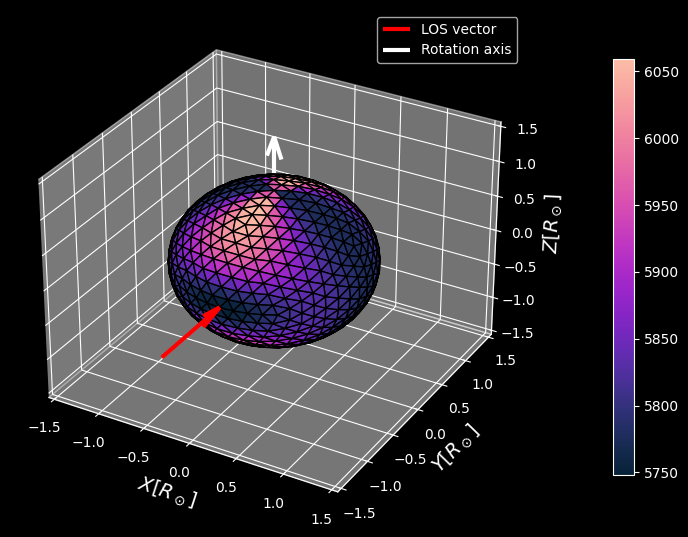

In [46]:
plt.style.use('dark_background')
#plt.style.use(plt.rcParamsDefault)

fig, axes = plot_3D(
    m_harm_spots,
    0, # property to be mapped - can be either a string or an integer
)